In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import pandas as pd

# Data exploration

We first load the data. As an example, we select the first data point and normalize the 70 epochs over 20 minutes.

In [8]:
result_dir = "../code/games/pong/results_demo/Simon/BALL_SPEED_1.0/"
simulations = [os.path.join(result_dir, x) for x in os.listdir(result_dir)]
print(simulations)

['../code/games/pong/results_demo/Simon/BALL_SPEED_1.0/event_recording-1689280746.6048787.json']


In [9]:
min20 = 20*60

In [10]:
def get_simulation_results(simulation):
    with open(simulation,"r") as f:
        data_point = json.load(f)

        simulation_results = data_point[1:]


        scale = min20/simulation_results[-1]['norm_timestamp']
        # normalize time
        for i in range(len(simulation_results)):
            simulation_results[i]["scaled_time"] = simulation_results[i]["norm_timestamp"]*scale
    return simulation_results

In [11]:
simulation_results = get_simulation_results(simulations[0])

Now, divide the actions per minutes, in order to obtain the statistics per minute.

In [12]:
# per minute splits 
def split_per_minute(simulation_results):
    minutes_recordings = []
    j = 0
    for i in range(60, 1201, 60):

        per_minute_recordings = []

        for s in simulation_results:
            if s["scaled_time"]>i-60 and s["scaled_time"]<=i:
                per_minute_recordings.append(s)
                j+=1

        minutes_recordings.append(per_minute_recordings)

    return minutes_recordings
    
minutes_recordings = split_per_minute(simulation_results)
print("Number of minutes:", len(minutes_recordings))

Number of minutes: 20


Let's explore the data for the 2nd minute (between 60 and 120 seconds):

In [13]:
minutes_recordings[1]

[{'norm_timestamp': 11.242967128753662,
  'event': 'ball bounce',
  'scaled_time': 60.54154748695727},
 {'norm_timestamp': 11.339832782745361,
  'event': 'ball bounce',
  'scaled_time': 61.06315326271335},
 {'norm_timestamp': 11.351291418075562,
  'event': 'ball return',
  'scaled_time': 61.124856148351505},
 {'norm_timestamp': 11.454958438873291,
  'event': 'ball bounce',
  'scaled_time': 61.68308617700701},
 {'norm_timestamp': 11.558073282241821,
  'event': 'ball return',
  'scaled_time': 62.23834282010796},
 {'norm_timestamp': 11.658407926559448,
  'event': 'ball bounce',
  'scaled_time': 62.77862854397238},
 {'norm_timestamp': 11.669171571731567,
  'event': 'ball bounce',
  'scaled_time': 62.836589020762716},
 {'norm_timestamp': 11.778896808624268,
  'event': 'ball return',
  'scaled_time': 63.427441556733214},
 {'norm_timestamp': 11.891107559204102,
  'event': 'ball bounce',
  'scaled_time': 64.03167817923494},
 {'norm_timestamp': 11.985353946685791,
  'event': 'ball bounce',
  's

All set! Now let's compute some statistics on this data:

In [14]:
def filter_events(minute):
    bounces = [e for e in minute if e["event"]=="ball bounce"]
    hits = [e for e in minute if e["event"]=="ball return"]
    
    # detect aces
    aces = []
    for i in range(len(minute)):
        if minute[i]["event"]=="motor layout: 0":
            # try to find next ace
            for j in range(0, len(minute)-i):
                if minute[i+j]["event"]=="ball return":
                    break # no ace
                if minute[i+j]["event"]=="ball missed":
                    aces.append(minute[i+j]) # ace detected
                    break
                    
    # detect long_rallies
    rallies = []
    for i in range(len(minute)):
        
        if minute[i]["event"]=="motor layout: 0":
            
            rally = []
            
            # try to find next return
            for j in range(0, len(minute)-i):
                if minute[i+j]["event"]=="ball return":
                    rally.append(minute[i+j])
                if minute[i+j]["event"]=="ball missed":
                    rallies.append(rally)
                    break
                    
    rally_end=[] 
    for i in range(len(minute)):
        if minute[i]["event"]=="ball missed":
            rally_end.append(minute[i])
                                 
    return {
        "bounces": bounces,
        "aces":aces,
        "hits":hits,
        "rallies":rallies,
        "misses": rally_end
    }

In [15]:
stats = filter_events(simulation_results)

In [16]:
def stats_to_scatter(stats):
    plt.figure()
    ax = plt.subplot(111)
    keys = list(stats.keys())
    for i in range(len(keys)):

        label = keys[i]
        if label!="rallies":
            times =  [s["scaled_time"] for s in stats[label]]
            ax.scatter(times, [i for _ in range(len(times))], label=label)
        else:
            last_times = [s[-1]["scaled_time"] for s in stats[label] if len(s)>3]
            ax.scatter(last_times, [i for _ in range(len(last_times))], label="long rallies (>3)")

    ax.set_yticks([])
    ax.set_ylim(4.1, -0.1)
    ax.set_xlabel("seconds")
    ax.legend()
    return ax

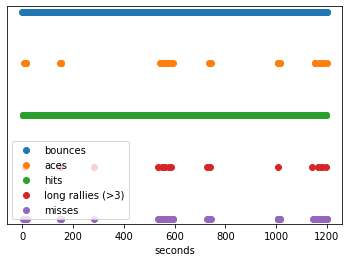

In [17]:
ax = stats_to_scatter(stats)

In [18]:
stats["misses"][0]

{'norm_timestamp': 0.6410953998565674,
 'event': 'ball missed',
 'scaled_time': 3.452194349552353}

Now, display as a vector

In [19]:
# create a numpy array per second, with the events
def stats_to_image(stats):
    event_array = np.zeros((4,1200))

    keys = list(stats.keys())
    for i in range(len(keys)):

        label = keys[i]
        if label!="rallies":
            times =  [int(np.round(s["scaled_time"])) for s in stats[label]]
            for t in times:
                if t<min20:
                    event_array[i, t] = 1
        else:
            last_times = [int(np.round(s[-1]["scaled_time"])) for s in stats[label] if len(s)>3]
            for t in last_times:
                if t<min20:
                    event_array[i, t] = 1
    return event_array

In [21]:
image = stats_to_image(stats)
ax = stats_to_scatter(stats)
ax.imshow(image, aspect="auto")

IndexError: index 4 is out of bounds for axis 0 with size 4

Finally, let's get the stats per minute:

In [22]:
def get_minute_stats(image):
    minute_stats = []

    for t in range(0, image.shape[1], 60):
        minute = image[:, t:t+60]
        stats = minute.mean(1)
        minute_stats.append(stats)

    return minute_stats

In [23]:
minute_stats = get_minute_stats(image)

NameError: name 'image' is not defined

In [24]:
# transform as pd:
def stats_to_pd(minute_stats):
    data_dict = []
    for i in range(len(minute_stats)):
        d = [{"time":i, "value":minute_stats[i][0], "event_type":"bounce"},
             {"time":i, "value":minute_stats[i][1], "event_type":"aces"},
             {"time":i, "value":minute_stats[i][2], "event_type":"hits"},
             {"time":i, "value":minute_stats[i][3], "event_type":"long_rallies"}
            ]
        data_dict+=(d)

    df = pd.DataFrame(data_dict)
    return df

df = stats_to_pd(minute_stats)
df

NameError: name 'minute_stats' is not defined

In [18]:
sns.scatterplot(df[df.event_type=="hits"], x="time",y="value")

NameError: name 'df' is not defined

Nice! Now let's analyze all the data.

## Results on DQN

In [25]:
def divide_dataset(data, chunk_size):
    chunks = []
    current_chunk = []
    current_time = data[0]['scaled_time']
    
    for item in data:
        if item['scaled_time'] - current_time <= chunk_size:
            current_chunk.append(item)
        else:
            chunks.append(current_chunk)
            current_chunk = [item]
            current_time = item['scaled_time']
    
    if current_chunk:
        chunks.append(current_chunk)
    
    return chunks

In [26]:
def get_rallies_per_minutes(stats):
    rallies = stats["rallies"]
    ends = stats["misses"]
    
    hits_per_rallies = []
    for i in range(len(rallies)):
        v = {"value":len(rallies[i]),
        "time":ends[i]["scaled_time"]}
        hits_per_rallies.append(v)
    return hits_per_rallies

In [27]:
chunk_size = 30

def get_aces_ratio(simulation_results):
    sim = [x for x in simulation_results if x["event"]!="ball bounce"]
    chunks = divide_dataset(sim, chunk_size)
    
    aces_across_time = []
    for c in range(len(chunks)):
        events_without_bounce = chunks[c] # this is not useful here
        game_started_next_hit, game_started_next_miss = [], []
        for i in range(len(events_without_bounce) - 1): # iterate up to the second-to-last element
            if events_without_bounce[i]['event'] == 'motor layout: 0':
                next_event = events_without_bounce[i+1]
                if next_event['event'] == 'ball missed' :
                    game_started_next_miss.append(next_event)
                elif next_event['event'] == 'ball return' :
                    game_started_next_hit.append(next_event)

        aces = len(game_started_next_miss)
        successfull_init_returns = len(game_started_next_hit)
        ratio_aces = aces/(aces+successfull_init_returns+1e-9)
        aces_across_time.append({"time":c*chunk_size,
                                "value":ratio_aces*100})
    return aces_across_time

def get_percentage_long(simulations_results):
    sim = [x for x in simulation_results if x["event"]!="ball bounce"]
    chunks = divide_dataset(sim, chunk_size)

    percentage_across = []
    for c in range(len(chunks)):
        rallies = [x for x in chunks[c] if x["event"]!="ball missed" and x["event"]!="game begin"]
        num_rallies = len([x for x in chunks[c] if x["event"]=="motor layout: 0"])

        n=0
        length_rallies = []
        for i in range(len(rallies)):

            if rallies[i]["event"]=="ball return":
                n=n+1
            else:
                length_rallies.append(n)
                n=0
        
        if len(length_rallies):
            percentage_long = len([x for x in length_rallies if x>3])/len(length_rallies)
            percentage_across.append({"time":c*chunk_size,
                                    "value":percentage_long*100})

    return percentage_across


def get_rally_hits(simulations_results):
    sim = [x for x in simulation_results if x["event"]!="ball bounce"]
    chunks = divide_dataset(sim, chunk_size)

    rally_hits = []
    for c in range(len(chunks)):
        rallies = [x for x in chunks[c] if x["event"]!="ball missed" and x["event"]!="game begin"]
        num_rallies = len([x for x in chunks[c] if x["event"]=="motor layout: 0"])

        n=0
        length_rallies = []
        for i in range(len(rallies)):

            if rallies[i]["event"]=="ball return":
                n=n+1
            else:
                length_rallies.append(n)
                n=0
        
        if len(length_rallies):
            mean_length = np.mean(length_rallies)
            rally_hits.append({"time":c*chunk_size,
                                    "value":mean_length})

    return rally_hits


In [28]:
# loop over simulations
hits_per_rally = []
aces_ratios = []
long_ratios = []

for ball_speed in [1.0]:
    result_dir = "../code/games/pong/results/DQN/BALL_SPEED_{}/".format(ball_speed)
    simulations = [os.path.join(result_dir, x) for x in os.listdir(result_dir)]

    for r in simulations:
        simulation_results = get_simulation_results(r)
        stats = filter_events(simulation_results)
        
        h = get_rally_hits(stats)
        df=pd.DataFrame(h)
        df["ball_speed"] = ball_speed
        hits_per_rally.append(df)
        
        a = get_aces_ratio(simulation_results)
        df = pd.DataFrame(a)
        df["ball_speed"] = ball_speed
        aces_ratios.append(df)
        
        p = get_percentage_long(simulation_results)
        df = pd.DataFrame(p)
        df["ball_speed"] = ball_speed
        long_ratios.append(df)
        
H = pd.concat(hits_per_rally)
A = pd.concat(aces_ratios)
L = pd.concat(long_ratios)

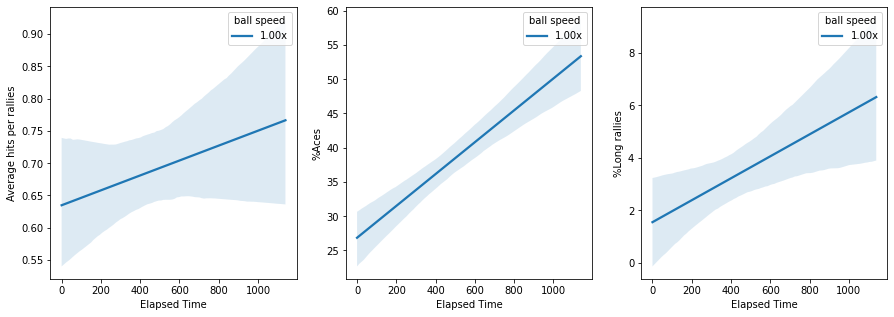

In [29]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)

sns.regplot(x="time", y="value", data=H[H.ball_speed==1.0], ax = ax, scatter=False, label="1.00x")
sns.regplot(x="time", y="value", data=H[H.ball_speed==2.0], ax=ax, scatter=False, label="2.00x")
sns.regplot(x="time", y="value", data=H[H.ball_speed==0.5], ax=ax, scatter=False, label="0.50x")
ax.legend(title="ball speed")
ax.set_ylabel("Average hits per rallies")
ax.set_xlabel("Elapsed Time")

ax = plt.subplot(1,3,2)

sns.regplot(x="time", y="value", data=A[A.ball_speed==1.0], ax = ax, scatter=False, label="1.00x")
sns.regplot(x="time", y="value", data=A[A.ball_speed==2.0], ax=ax, scatter=False, label="2.00x")
sns.regplot(x="time", y="value", data=A[A.ball_speed==0.5], ax=ax, scatter=False, label="0.50x")
ax.legend(title="ball speed")
ax.set_ylabel("%Aces")
ax.set_xlabel("Elapsed Time")


ax = plt.subplot(1,3,3)

sns.regplot(x="time", y="value", data=L[L.ball_speed==1.0], ax = ax, scatter=False, label="1.00x")
sns.regplot(x="time", y="value", data=L[L.ball_speed==2.0], ax=ax, scatter=False, label="2.00x")
sns.regplot(x="time", y="value", data=L[L.ball_speed==0.5], ax=ax, scatter=False, label="0.50x")
ax.legend(title="ball speed")
ax.set_ylabel("%Long rallies")
ax.set_xlabel("Elapsed Time")
plt.show()

In [52]:
os.listdir("../code/games/pong/results/DQN/")

['BALL_SPEED_1.0']

# Results per model

In [63]:
models = os.listdir("../code/games/pong/results_demo/")
models

['Hebbian_Simon', 'Hugo', 'Simon']

In [64]:
# Results across different models
# loop over simulations
hits_per_rally = []
aces_ratios = []
long_ratios = []
ball_speed = 1.0

for model in models:
    result_dir = "../code/games/pong/results_demo/{}/BALL_SPEED_{}/".format(model, ball_speed)
    if not os.path.exists(result_dir):
        print("skip", result_dir)
        continue
    simulations = [os.path.join(result_dir, x) for x in os.listdir(result_dir)]

    for r in simulations:
        simulation_results = get_simulation_results(r)
        stats = filter_events(simulation_results)
        
        h = get_rallies_per_minutes(stats)
        df=pd.DataFrame(h)
        df["ball_speed"] = ball_speed
        df["model"] = model
        hits_per_rally.append(df)
        
        a = get_aces_ratio(simulation_results)
        df = pd.DataFrame(a)
        df["ball_speed"] = ball_speed
        df["model"] = model
        aces_ratios.append(df)
        
        p = get_percentage_long(simulation_results)
        df = pd.DataFrame(p)
        df["ball_speed"] = ball_speed
        df["model"] = model
        long_ratios.append(df)
        
H = pd.concat(hits_per_rally)
A = pd.concat(aces_ratios)
L = pd.concat(long_ratios)

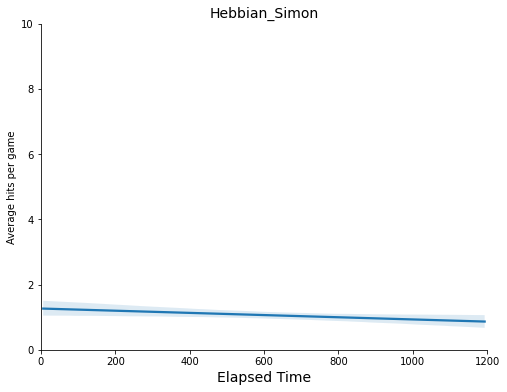

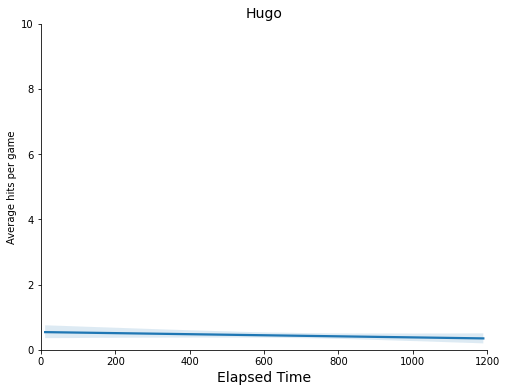

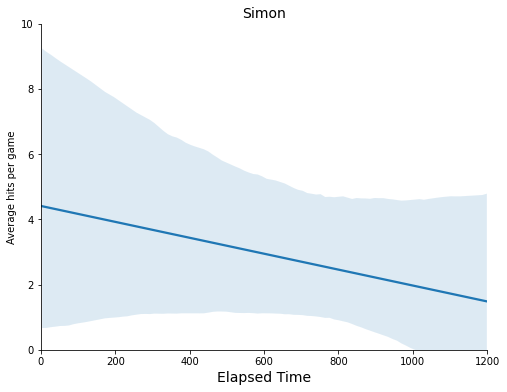

In [65]:
xlim = (0, 1200) # You need to specify these values
ylim = (0, 10) # You need to specify these values

for model in models:
    # Create a new figure for H data
    fig, ax = plt.subplots(figsize=(8,6))
    sns.regplot(x="time", y="value", data=H[H.model==model], ax=ax, scatter=False, label=model)
    ax.set_title(model, fontsize = 14)
    ax.set_xlabel("Elapsed Time", fontsize = 14)
    ax.set_ylabel('Average hits per game')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.spines[['top', 'right']].set_visible(False)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


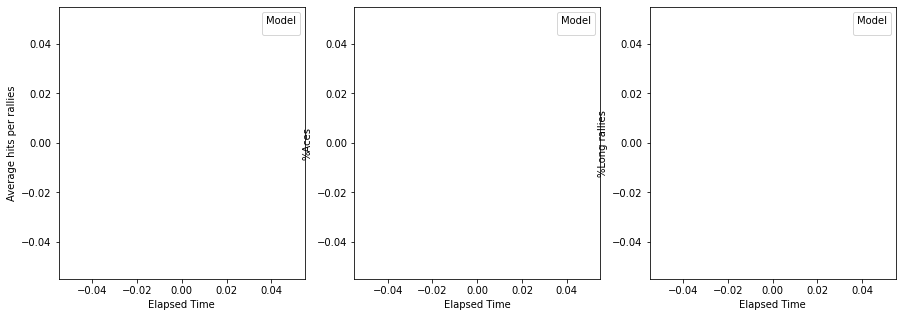

In [35]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)

for model in models:
    sns.regplot(x="time", y="value", data=H[H.model==model], ax = ax, scatter=False, label=model)
ax.legend(title="Model")
ax.set_ylabel("Average hits per rallies")
ax.set_xlabel("Elapsed Time")

ax = plt.subplot(1,3,2)

for model in models:
    sns.regplot(x="time", y="value", data=A[A.model==model], ax = ax, scatter=False, label=model)
ax.legend(title="Model")
ax.set_ylabel("%Aces")
ax.set_xlabel("Elapsed Time")


ax = plt.subplot(1,3,3)

for model in models:
    sns.regplot(x="time", y="value", data=L[L.model==model], ax = ax, scatter=False, label=model)
ax.legend(title="Model")
ax.set_ylabel("%Long rallies")
ax.set_xlabel("Elapsed Time")
plt.show()